In [223]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk
import math

import os
import cProfile, pstats, io
#import memory_profiler
import psutil
import gc

# Enabling eager execution and set other configurations

In [224]:
tf.enable_eager_execution()
process = psutil.Process(os.getpid())

print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
#https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

#https://pypi.org/project/memory-profiler/ - did not use it

UNK = '</s>'
FILLER = '</fill>'

MAX_BATCH_SIZE = 1024
MAX_WORD_COUNT = 40

NO_LABEL = 'NO_LABEL'

7346.98828125 MB


# Load Google vectors

In [225]:
dirname = os.getcwd()
datasetPath = os.path.join(dirname, 'datasets/')
outfile = datasetPath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(datasetPath+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)

print(googleSet.shape)
print(googleSet.head())

# TO BE DONE - Appropriate value should be added for FILLER (or) it has to be trained
fill_data = {0:FILLER}
for i in range(1, googleSet.shape[1]):
    fill_data[i] = i
googleSet = googleSet.append(fill_data, ignore_index=True)

print(googleSet.shape)
print(googleSet.head())

temp = list(googleCorpus)
temp.append(FILLER)
googleCorpus = set(temp)
corpus_length = len(google_corpus_word_to_int)
google_corpus_word_to_int[FILLER] = corpus_length
google_corpus_int_to_word[corpus_length] = FILLER


googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]

(1965717, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  
(1965718, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 

In [226]:
#UNK = '<unk>'

#glovePath = '/media/kandy/hdd/master-thesis/datasets/'
#outfile = glovePath +'glove_word_corpus.pic'

#with open(outfile, 'rb') as pickle_file:    
#    gloveCorpus, glove_corpus_word_to_int, glove_corpus_int_to_word = pickle.load(pickle_file)
#gloveSet = pd.read_csv(glovePath+'glove.42B.10d.txt', sep=' ', header=None)
#print(gloveSet.shape)
#print(gloveSet.head())

#gloveWords = gloveSet.iloc[:,0:1]
#gloveVectors = gloveSet.iloc[:,1:]

# Load training and test dataset

In [227]:
#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK-less-40-words.csv', sep=' ', header=None )
treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-40-UNK-NOLABEL.csv', sep=' ', header=None )

treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

treeDataframe.head()

,sentence,tree
0,pierre </s> </s> </s> years old </s> will join...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,mr. </s> is chairman of elsevier n.v. </s> the...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,rudolph agnew </s> </s> years old and former c...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,the asbestos fiber </s> </s> </s> is unusually...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,lorillard inc. </s> the unit of new </s> loews...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


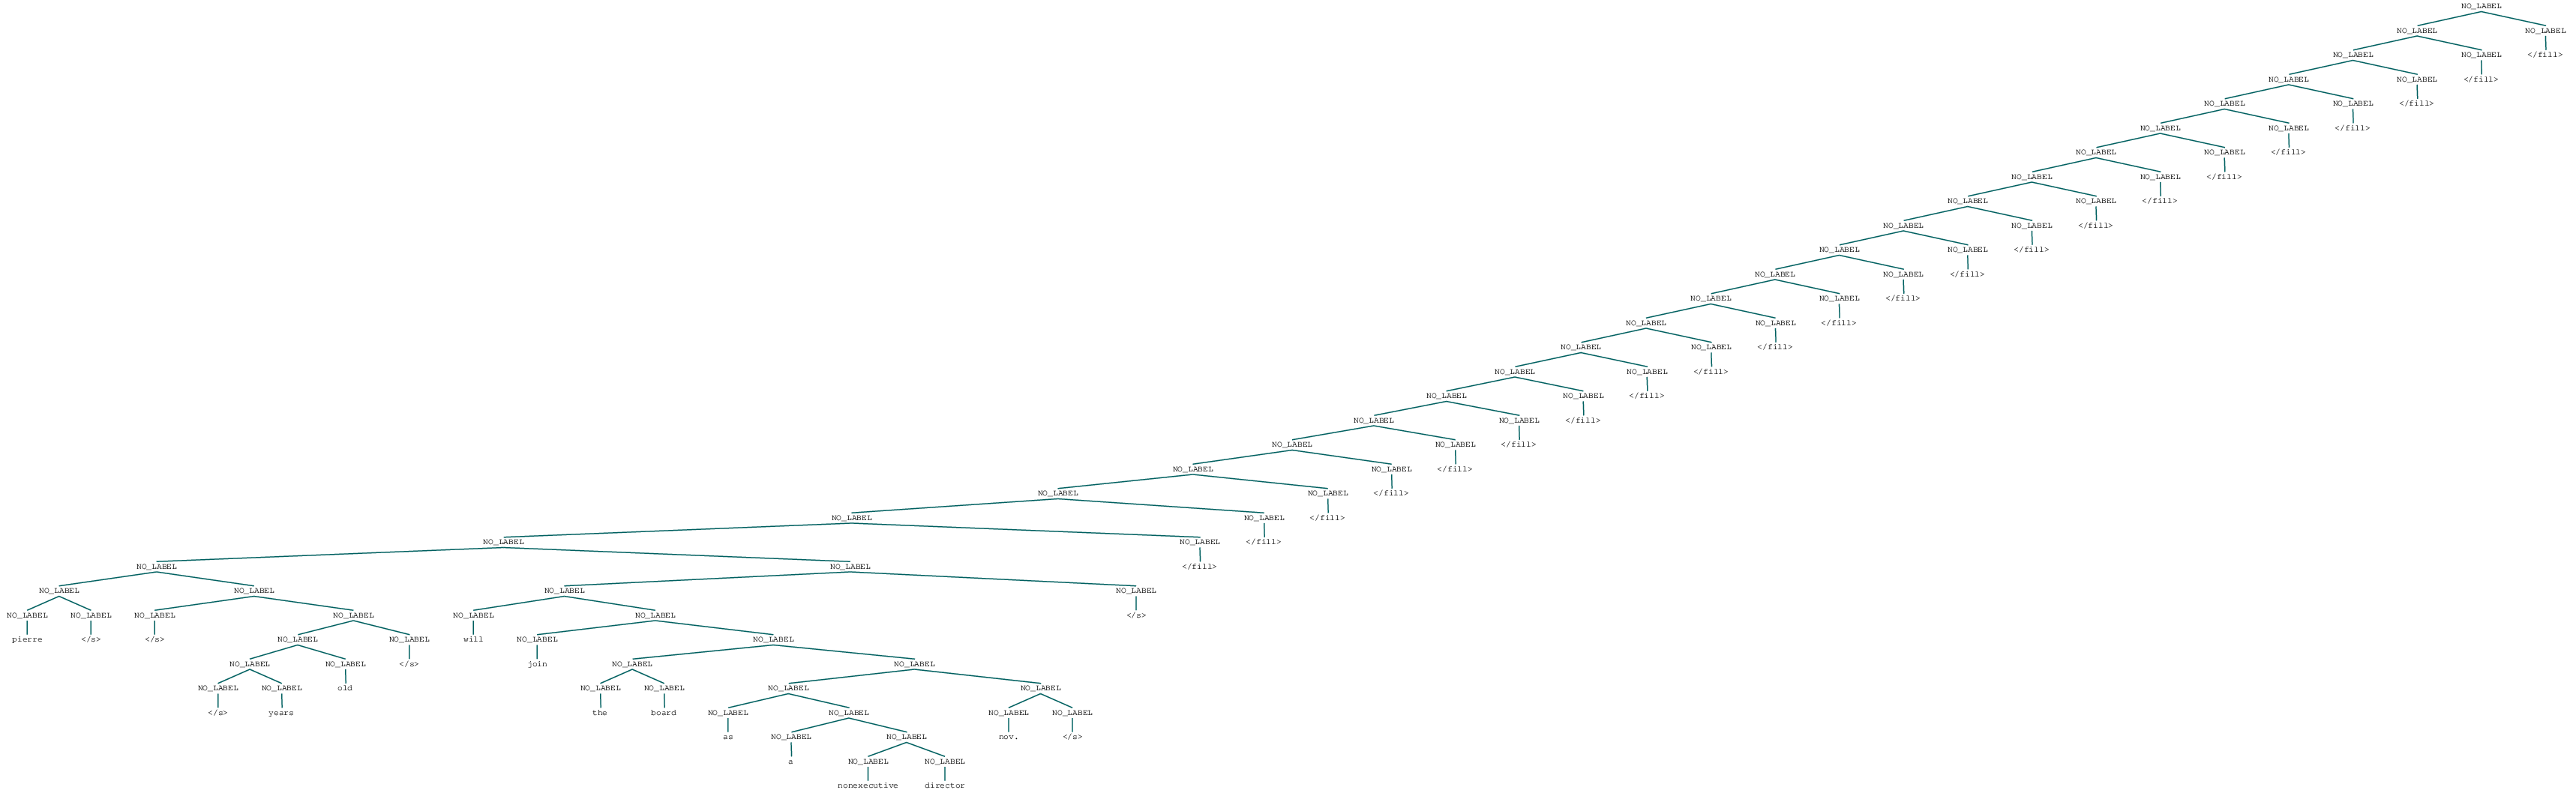

In [228]:
treeDataframe.iat[0,1]

In [265]:
def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)
treeDataframe_num.head()

,sentence,tree
0,"[353287, 920150, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,"[778656, 920150, 1025196, 261666, 920355, 5478...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,"[880384, 206120, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,"[1323513, 151538, 1349057, 920150, 920150, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,"[529848, 234617, 920150, 1323513, 1901239, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


In [266]:
#compute the tree formation index for the golden tree
# This does a depth first traversal of tree and gets the left child index of each sub-tree formation
def convert_tree(tree, leaves, input_list):
    if(type(tree[0]) == type('some string')):
        # we use the leaves() function to get the indexes of child elements
        # everytime when an element is found, it is important to remove them to avoid getting them reused
        leaveIndex = leaves.index(tree[0])
        leaves[leaveIndex]=''
        return leaveIndex
    
    leftIndex = convert_tree(tree[0], leaves, input_list)
    rightIndex = convert_tree(tree[1], leaves, input_list)
    input_list.append(leftIndex)
    return leftIndex

def convert_trees(tree):
    tree_combination= []
    tree_leaves = tree.leaves()
    convert_tree(tree, tree_leaves, tree_combination)
    
    # the indexes obtained for forming the tree assumes the size of the leaves is unchanged.
    # But everytime when a subtree is formed two nodes are merged together and hence size reduces
    
    # the below code is to make sure the index is updated as according to where the merge happened
    # all the indexes which are right to where the merge happened has to get subtracted by 1 
    # because of removal of a node
    
    for i in range(len(tree_combination)-1):
        for j in range(i+1, len(tree_combination)):
            if(tree_combination[j] > tree_combination[i]):
                tree_combination[j] = tree_combination[j] - 1
    return np.array(tree_combination)

columnList = []
for i in range(MAX_WORD_COUNT-1):
    columnList.append('c'+str(i))
#get the list of indexes and store it in column 'c'. Afterwards break the 'c' to MAX_WORD_COUNT-1 columns
treeDataframe_num['c'] = treeDataframe_num['tree'].apply(convert_trees)
treeDataframe_num[columnList] = pd.DataFrame(treeDataframe_num.c.values.tolist(), index= treeDataframe_num.index, dtype=np.int32)
treeDataframe_num.drop(columns=['c'], inplace=True)
treeDataframe_num.head()

,sentence,tree,c0,c1,c2,c3,c4,c5,c6,c7,...,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38
0,"[353287, 920150, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,2,2,2,1,0,3,6,...,0,0,0,0,0,0,0,0,0,0
1,"[778656, 920150, 1025196, 261666, 920355, 5478...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,4,8,7,6,5,4,3,...,0,0,0,0,0,0,0,0,0,0
2,"[880384, 206120, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,2,2,4,8,7,6,5,...,0,0,0,0,0,0,0,0,0,0
3,"[1323513, 151538, 1349057, 920150, 920150, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,1,0,2,1,0,2,6,5,...,3,3,2,1,0,0,0,0,0,0
4,"[529848, 234617, 920150, 1323513, 1901239, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,2,4,5,4,3,7,6,...,0,0,0,0,0,0,0,0,0,0


In [268]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.2)
print(treeDF_train.shape)
print(treeDF_test.shape)

(35067, 41)
(8767, 41)


In [232]:
#treeDF_train = treeDataframe_num.iloc[treeDataframe_num.shape[0]-50:treeDataframe_num.shape[0]]
#treeDF_test = treeDataframe_num.iloc[0:treeDataframe_num.shape[0]-50]
#print(treeDF_train.shape)
#print(treeDF_test.shape)

# Model and the Parameters

In [179]:
STATE_SIZE = 10
embeddings = tfe.Variable(name='embeddings', validate_shape= googleVectors.shape, 
                          initial_value=googleVectors.values, 
                          dtype=tf.float32, trainable=False)
w = tfe.Variable(name='w', validate_shape=(2*googleVectors.shape[1], STATE_SIZE), 
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(2*googleVectors.shape[1], STATE_SIZE)),
                 dtype=tf.float32)
b = tfe.Variable(name='b', validate_shape=(1, STATE_SIZE),
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, STATE_SIZE)),
                 dtype=tf.float32)

w_score = tfe.Variable(name='w_score', validate_shape=(STATE_SIZE, 1), 
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(STATE_SIZE, 1)),
                 dtype=tf.float32)
b_score = tfe.Variable(name='b_score', validate_shape=(1, 1),
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, 1)),
                 dtype=tf.float32)

#print(w)
#print(b)
#print(w_score)
#print(b_score)

In [233]:
print(embeddings.shape)
lookup = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int['</s>'])
lookup = tf.reshape(lookup, shape=(1, lookup.shape[0]))
print(lookup)

(1965718, 10)
tf.Tensor(
[[ 0.09570312 -0.03881836  0.05883789  0.03930664 -0.01300049 -0.1484375
   0.07568359 -0.13378906  0.2890625   0.00370789]], shape=(1, 10), dtype=float32)


In [234]:
def compare_trees(actual, predicted):
    actual_sub_trees = actual.subtrees()
    
    
    total_count = 0.0 #len(actual_sub_trees)
    match_count = 0.0
    
    for sub_tree in actual_sub_trees:
        #print('Sub Tree:', sub_tree)
        #print(predicted_sub_trees)
        predicted_sub_trees = predicted.subtrees()
        for temp_tree in predicted_sub_trees:
            #print(' ', temp_tree)
            if(sub_tree == temp_tree):
                match_count = match_count + 1.0
                break
        total_count = total_count + 1.0
        #break
    #print('Match:', match_count,' Total:', total_count)
    
    return [match_count/total_count, match_count, total_count]

#compare_trees(treeDF_train.iat[2,1], treeDF_train.iat[2,1])

t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
sub_trees = t1.subtrees()
for sub_tree in sub_trees:
    print(sub_tree)

(S (NP I) (VP (V saw) (NP him)))
(NP I)
(VP (V saw) (NP him))
(V saw)
(NP him)


In [235]:
def embedding_lookup(input_words):
    words = tf.nn.embedding_lookup(embeddings, input_words)
    return words

In [236]:
gc.collect()

pr = cProfile.Profile()
pr.enable()

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

start_memory = process.memory_info().rss
start_time = timer()


# calculate the upper limit for BATCH_COUNT
BATCH_COUNT = int(math.ceil(treeDF_train.shape[0]/MAX_BATCH_SIZE))
print('StartMemory (MB): ', start_memory/(1024*1024))
print('Epoch Batch Loss Time(sec) Memory(MB)')

for epoch in range(1) :
     
    for batch_no in range(BATCH_COUNT):

        #print('Epoch:', epoch,'Batch:', batch_no,'/',BATCH_COUNT)
        
        # Recorded only batch-wise. that is enough to calculate gradients and apply them
        with tf.GradientTape() as tape:
            
            # Extract the appropriate batch data. For the last batch, the size of the data can be lesser
            start = batch_no * MAX_BATCH_SIZE
            stop = start + MAX_BATCH_SIZE
            mini_batch_data = treeDF_train.iloc[start:stop]
            BATCH_SIZE = mini_batch_data.shape[0]
            
            # get the word vectors - its shape will be (no. of sentence, no.of words, no. of states)
            data = embedding_lookup(mini_batch_data['sentence'])
            gold_data = embedding_lookup(mini_batch_data['sentence'])
            #data = tf.slice(embedding_lookup_out, [0,0,0], [BATCH_SIZE,MAX_WORD_COUNT,STATE_SIZE])
            #print(data.shape)
            
            NO_OF_SENTENCE = data.shape[0] # which is same as BATCH_SIZE
            NO_OF_WORDS = data.shape[1]

            total_predict_score = tf.zeros((BATCH_SIZE,1))
            total_actual_score = tf.zeros((BATCH_SIZE,1))
            
            # enumerate through all the word combinations
            # find the best combination, replace with respective two words
            # do it untill only one word is present
            for word_counter in range(NO_OF_WORDS-1):

                # concatenate the word combinations - first data will contain 1st to n-1th word and 
                # second data will contain 2nd to nth word
                first_data = tf.slice(data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                second_data = tf.slice(data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                concatenated_data = tf.concat([first_data, second_data], axis=2)

                # applying linear and non-linear transformation to output STATE_SIZE dimensions
                # this becomes the representation vector for phrases
                reshaped_data = tf.reshape(concatenated_data, (-1,2*STATE_SIZE))
                output_data = tf.tanh(tf.matmul(reshaped_data, w) + b)
                reshaped_output_data = tf.reshape(output_data, (NO_OF_SENTENCE,-1,STATE_SIZE))
                
                # compute score of the above transformation to rank them
                scored_data = tf.matmul(output_data, w_score) + b_score
                reshaped_scored_data = tf.reshape(scored_data, (NO_OF_SENTENCE,-1,1))
                
                max_scored_data = tf.reduce_max(reshaped_scored_data, axis=1)
                squeezed_max_score = tf.squeeze(max_scored_data)
                total_predict_score = tf.add(total_predict_score, squeezed_max_score)
                
                # get the list of indexes whose scores are high
                argmax_score = tf.argmax(reshaped_scored_data, axis=1, output_type=tf.int32)
                squeeze_argmax_score = tf.squeeze(argmax_score)
                # convert the indexing to support reshaping of 2D matrix. this is important to
                # remove the word vector at argmax position
                range_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
                range_data = tf.reshape(range_data, (NO_OF_SENTENCE,1))
                range_data = range_data + argmax_score
                # convert the indexes to support reshaping of 2D matrix with a word 
                # removed for every sentence. This is important because having got the word removed
                # this will help replace the phrase vector at argmax position for sentences with n-1 words
                range_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
                range_data_minus = tf.reshape(range_data_minus, (NO_OF_SENTENCE,1))
                range_data_minus = range_data_minus + argmax_score

                # create a bool list with true values of size sentences*words
                # replace the values at argmax position with false
                reshaped_data = tf.reshape(data, (-1,STATE_SIZE))
                range_data_list = tf.squeeze(range_data).numpy().tolist()
                bool_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
                for i in range_data_list:
                    bool_mask_data[i] = False
                # use the boolean mask to filter the rows (axis=0)
                reshaped_new_data = tf.boolean_mask(reshaped_data, bool_mask_data, axis=0)
                
                # create a bool list with true values of size sentences*(words-1)
                # replace the values at argmax position with false
                range_data_minus_list = tf.squeeze(range_data_minus).numpy().tolist()
                bool_mask_data = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
                for i in range_data_minus_list:
                    bool_mask_data[i] = False
                # replace the input words with phrase vectors at argmax position(bool mask data)
                data = tf.where(bool_mask_data, reshaped_new_data, output_data)
                data = tf.reshape(data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))
                
                # REPEAT THE SAME PROCESS (with minor changes) FOR GOLDEN TREE SCORE COMPUTATION
                first_gold_data = tf.slice(gold_data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                second_gold_data = tf.slice(gold_data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                concatenated_gold_data = tf.concat([first_gold_data, second_gold_data], axis=2)
                reshaped_gold_data = tf.reshape(concatenated_gold_data, (-1,2*STATE_SIZE))
                output_gold_data = tf.tanh(tf.matmul(reshaped_gold_data, w) + b)
                reshaped_output_gold_data = tf.reshape(output_gold_data, (NO_OF_SENTENCE,-1,STATE_SIZE))
                
                scored_gold_data = tf.matmul(output_gold_data, w_score) + b_score
                reshaped_scored_gold_data = tf.reshape(scored_gold_data, (NO_OF_SENTENCE,-1,1))
                
                #get the argmax score which is stored in mini_batch_data
                argmax_gold_score = tf.convert_to_tensor(mini_batch_data['c'+str(word_counter)], dtype=tf.int32)
                argmax_gold_score = tf.reshape(argmax_gold_score, shape=(argmax_gold_score.shape[0], 1))
                squeeze_argmax_gold_score = tf.squeeze(argmax_gold_score)
                
                range_gold_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
                range_gold_data = tf.reshape(range_gold_data, (NO_OF_SENTENCE,1))
                range_gold_data = range_gold_data + argmax_gold_score
                
                #the score of intended combination is chosen and added up
                max_scored_gold_data = tf.gather(scored_gold_data, range_gold_data)
                squeezed_max_gold_score = tf.squeeze(max_scored_gold_data)
                total_actual_score = tf.add(total_actual_score, squeezed_max_gold_score)
                
                range_gold_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
                range_gold_data_minus = tf.reshape(range_gold_data_minus, (NO_OF_SENTENCE,1))
                range_gold_data_minus = range_gold_data_minus + argmax_gold_score
                
                reshaped_gold_data = tf.reshape(gold_data, (-1,STATE_SIZE))
                range_gold_data_list = tf.squeeze(range_gold_data).numpy().tolist()
                bool_gold_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
                for i in range_gold_data_list:
                    bool_gold_mask_data[i] = False
                    
                reshaped_new_gold_data = tf.boolean_mask(reshaped_gold_data, bool_gold_mask_data, axis=0)
                
                range_gold_data_minus_list = tf.squeeze(range_gold_data_minus).numpy().tolist()
                bool_gold_mask_data1 = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
                for i in range_gold_data_minus_list:
                    bool_gold_mask_data1[i] = False

                gold_data = tf.where(bool_gold_mask_data1, reshaped_new_gold_data, output_gold_data)
                gold_data = tf.reshape(gold_data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))
                
                NO_OF_SENTENCE = data.shape[0]
                NO_OF_WORDS = data.shape[1]
                
            #get the scores and compute the loss
            final_predict_score = tf.squeeze(reshaped_scored_data)
            total_predict_score = tf.add(total_predict_score, final_predict_score)
            final_actual_score = tf.squeeze(reshaped_scored_gold_data)
            total_actual_score = tf.add(total_actual_score, final_actual_score)
            
            losses = tf.abs(total_predict_score - total_actual_score)
            avg_loss = tf.reduce_mean(losses)
            
            # use the gradient tape to update the parameter values
            grads = tape.gradient(avg_loss, [w,b,w_score,b_score])
            grad_op = optimizer.apply_gradients(zip(grads, [w,b,w_score,b_score]), 
                                      global_step=tf.train.get_or_create_global_step())
            #print(avg_loss)
            
            stop_memory = process.memory_info().rss
            stop_time = timer()
            print(epoch, batch_no, avg_loss.numpy(), (stop_time - start_time), ((stop_memory - start_memory) /(1024*1024)))
            #gc.collect()

    if(epoch %10 == 0):
        parameters = [w, b, w_score, b_score]
        with open('parameters'+str(timer())+'.pic', 'wb') as pickle_file:    
            pickle.dump(parameters, pickle_file)

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
#print(s.getvalue())

StartMemory (MB):  10217.06640625
Epoch Batch Loss Time(sec) Memory(MB)
0 0 7.880881 3.263662140001543 10.55078125
0 1 3.8824992 6.334433418989647 10.234375
0 2 7.869759 9.402319280983647 10.23828125
0 3 3.8791142 12.46130353899207 10.23828125
0 4 7.8643727 15.522250076988712 10.23828125
0 5 3.885794 18.542782187985722 10.23828125
0 6 7.8600473 21.59257276498829 10.23828125
0 7 3.8827074 24.6525529549981 10.23828125
0 8 7.868552 27.683647995989304 10.23828125
0 9 3.8749294 30.732077852997463 10.23828125
0 10 7.8718476 33.78275756401126 10.23828125
0 11 3.8920443 36.8108562050038 10.23828125
0 12 7.862309 39.853246076003416 10.23828125
0 13 3.876661 42.880945067998255 10.23828125
0 14 7.8753366 45.918132416991284 10.23828125
0 15 3.8820403 48.965766256995266 10.23828125
0 16 7.883175 52.01548180298414 10.23828125
0 17 3.8709235 55.06174522699439 10.2421875
0 18 7.8894854 58.09248376599862 10.2421875
0 19 3.8653467 61.14865055598784 10.2421875
0 20 7.883027 64.19161976300529 10.2421875
0

### Prediction

In [290]:
gc.collect()

pr = cProfile.Profile()
pr.enable()

start_memory = process.memory_info().rss
start_time = timer()

# calculate the upper limit for BATCH_COUNT
BATCH_COUNT = int(math.ceil(float(treeDF_test.shape[0])/MAX_BATCH_SIZE))
result_set = pd.DataFrame(treeDF_test, index=treeDF_test.index)

for batch_no in range(BATCH_COUNT):

    print(batch_no,'/',BATCH_COUNT)

    # Extract the appropriate batch data. For the last batch, the size of the data can be lesser
    start = batch_no * MAX_BATCH_SIZE
    stop = start + MAX_BATCH_SIZE
    mini_batch_data = treeDF_test.iloc[start:stop]
    BATCH_SIZE = mini_batch_data.shape[0]

    # get the word vectors - its shape will be (no. of sentence, no.of words, no. of states)
    data = embedding_lookup(mini_batch_data['sentence'])
    #data = tf.slice(embedding_lookup_out, [0,0,0], [BATCH_SIZE,MAX_WORD_COUNT,STATE_SIZE])
    #print(data.shape)

    NO_OF_SENTENCE = data.shape[0] # which is same as BATCH_SIZE
    NO_OF_WORDS = data.shape[1]

    total_predict_score = tf.zeros((BATCH_SIZE,1))
    total_actual_score = tf.zeros((BATCH_SIZE,1))
    
    # enumerate through all the word combinations
    # find the best combination, replace with respective two words
    # do it untill only one word is present
    for word_counter in range(NO_OF_WORDS-1):

        # concatenate the word combinations - first data will contain 1st to n-1th word and 
        # second data will contain 2nd to nth word
        first_data = tf.slice(data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
        second_data = tf.slice(data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
        concatenated_data = tf.concat([first_data, second_data], axis=2)

        # applying linear and non-linear transformation to output STATE_SIZE dimensions
        # this becomes the representation vector for phrases
        reshaped_data = tf.reshape(concatenated_data, (-1,2*STATE_SIZE))
        output_data = tf.tanh(tf.matmul(reshaped_data, w) + b)
        reshaped_output_data = tf.reshape(output_data, (NO_OF_SENTENCE,-1,STATE_SIZE))

        # compute score of the above transformation to rank them
        scored_data = tf.matmul(output_data, w_score) + b_score
        reshaped_scored_data = tf.reshape(scored_data, (NO_OF_SENTENCE,-1,1))

        max_scored_data = tf.reduce_max(reshaped_scored_data, axis=1)
        squeezed_max_score = tf.squeeze(max_scored_data)
        total_predict_score = tf.add(total_predict_score, squeezed_max_score)

        # get the list of indexes whose scores are high
        argmax_score = tf.argmax(reshaped_scored_data, axis=1, output_type=tf.int32)
        squeeze_argmax_score = tf.squeeze(argmax_score)
        result_set.loc[mini_batch_data.index, 'c'+str(word_counter)] = squeeze_argmax_score.numpy().astype(int).tolist()
                                                                                 
        # convert the indexing to support reshaping of 2D matrix. this is important to
        # remove the word vector at argmax position
        range_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
        range_data = tf.reshape(range_data, (NO_OF_SENTENCE,1))
        range_data = range_data + argmax_score
        # convert the indexes to support reshaping of 2D matrix with a word 
        # removed for every sentence. This is important because having got the word removed
        # this will help replace the phrase vector at argmax position for sentences with n-1 words
        range_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
        range_data_minus = tf.reshape(range_data_minus, (NO_OF_SENTENCE,1))
        range_data_minus = range_data_minus + argmax_score

        # create a bool list with true values of size sentences*words
        # replace the values at argmax position with false
        reshaped_data = tf.reshape(data, (-1,STATE_SIZE))
        range_data_list = tf.squeeze(range_data).numpy().tolist()
        bool_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
        for i in range_data_list:
            bool_mask_data[i] = False
        # use the boolean mask to filter the rows (axis=0)
        reshaped_new_data = tf.boolean_mask(reshaped_data, bool_mask_data, axis=0)

        # create a bool list with true values of size sentences*(words-1)
        # replace the values at argmax position with false
        range_data_minus_list = tf.squeeze(range_data_minus).numpy().tolist()
        bool_mask_data = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
        for i in range_data_minus_list:
            bool_mask_data[i] = False
        # replace the input words with phrase vectors at argmax position(bool mask data)
        data = tf.where(bool_mask_data, reshaped_new_data, output_data)
        data = tf.reshape(data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))

        NO_OF_SENTENCE = data.shape[0]
        NO_OF_WORDS = data.shape[1]

accuracy = 0.0
predicted_tree_list = []
for i in range(result_set.shape[0]):
    one_row = result_set.iloc[i]
    words = one_row['sentence']
    words = [google_corpus_int_to_word[word] for word in words]
    sub_trees = [nltk.Tree(NO_LABEL,[word]) for word in words]

    for j in range(MAX_WORD_COUNT-1):
        combine_index = one_row['c'+str(j)]
        combine_index = int(combine_index)
        right_tree = sub_trees.pop(combine_index+1)
        left_tree = sub_trees.pop(combine_index)
        sub_trees.insert(combine_index, nltk.Tree(NO_LABEL, [left_tree, right_tree]))
    predicted_tree_list.append(sub_trees[0])
    temp_accuracy = compare_trees(one_row['tree'], sub_trees[0])
    accuracy = accuracy + temp_accuracy[0]
    
result_set['predict'] = pd.Series(predicted_tree_list, index=result_set.index)

stop_memory = process.memory_info().rss
stop_time = timer()
print(accuracy/treeDF_test.shape[0], (stop_time - start_time), ((stop_memory - start_memory) /(1024*1024)))
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
#print(s.getvalue())

0 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
0.5291621486211578 141.16544332401827 162.49609375


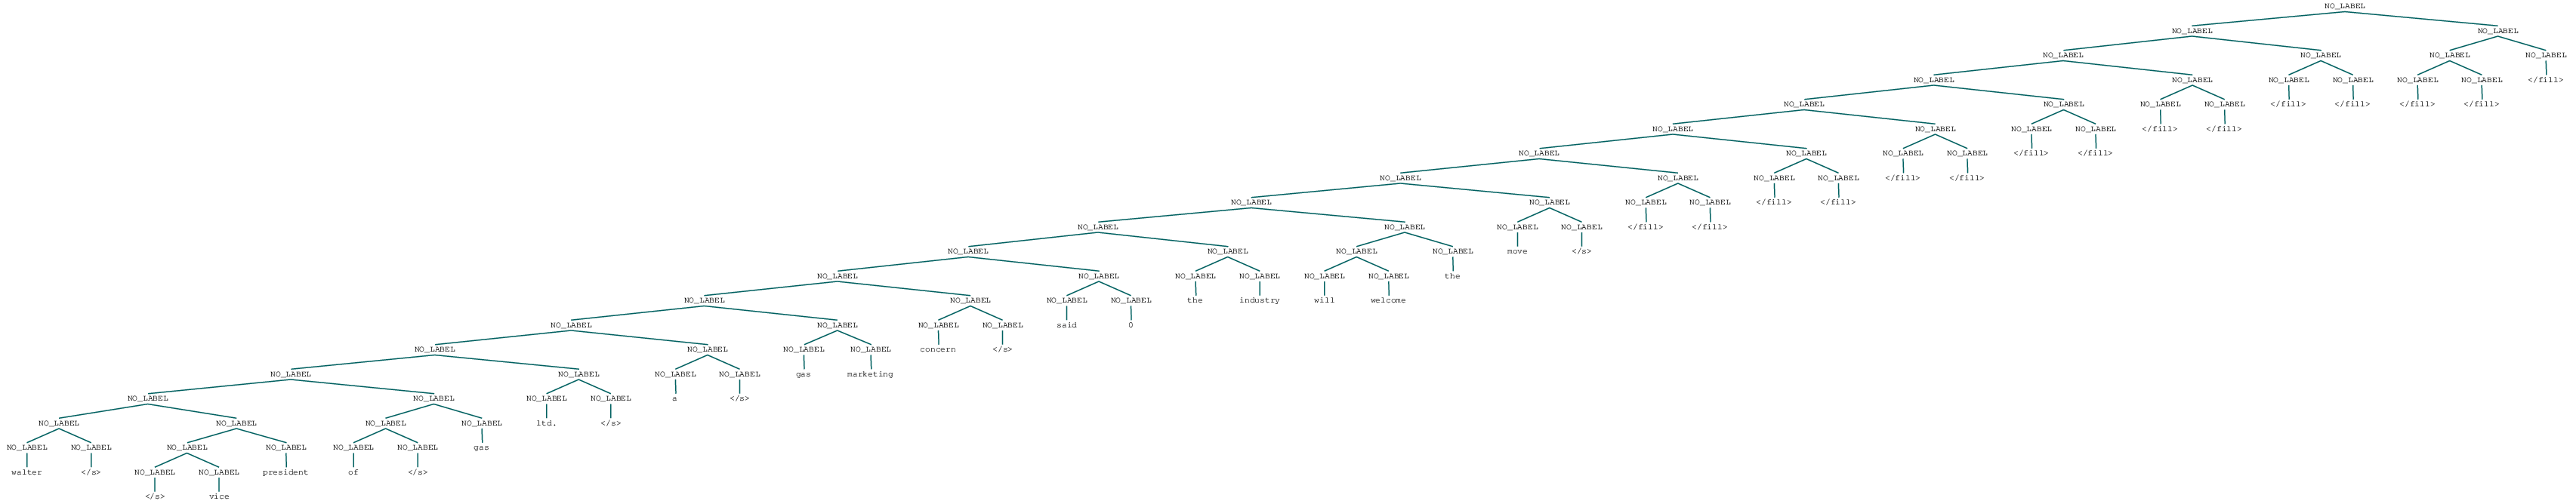

In [292]:
result_set.iloc[0]['predict']

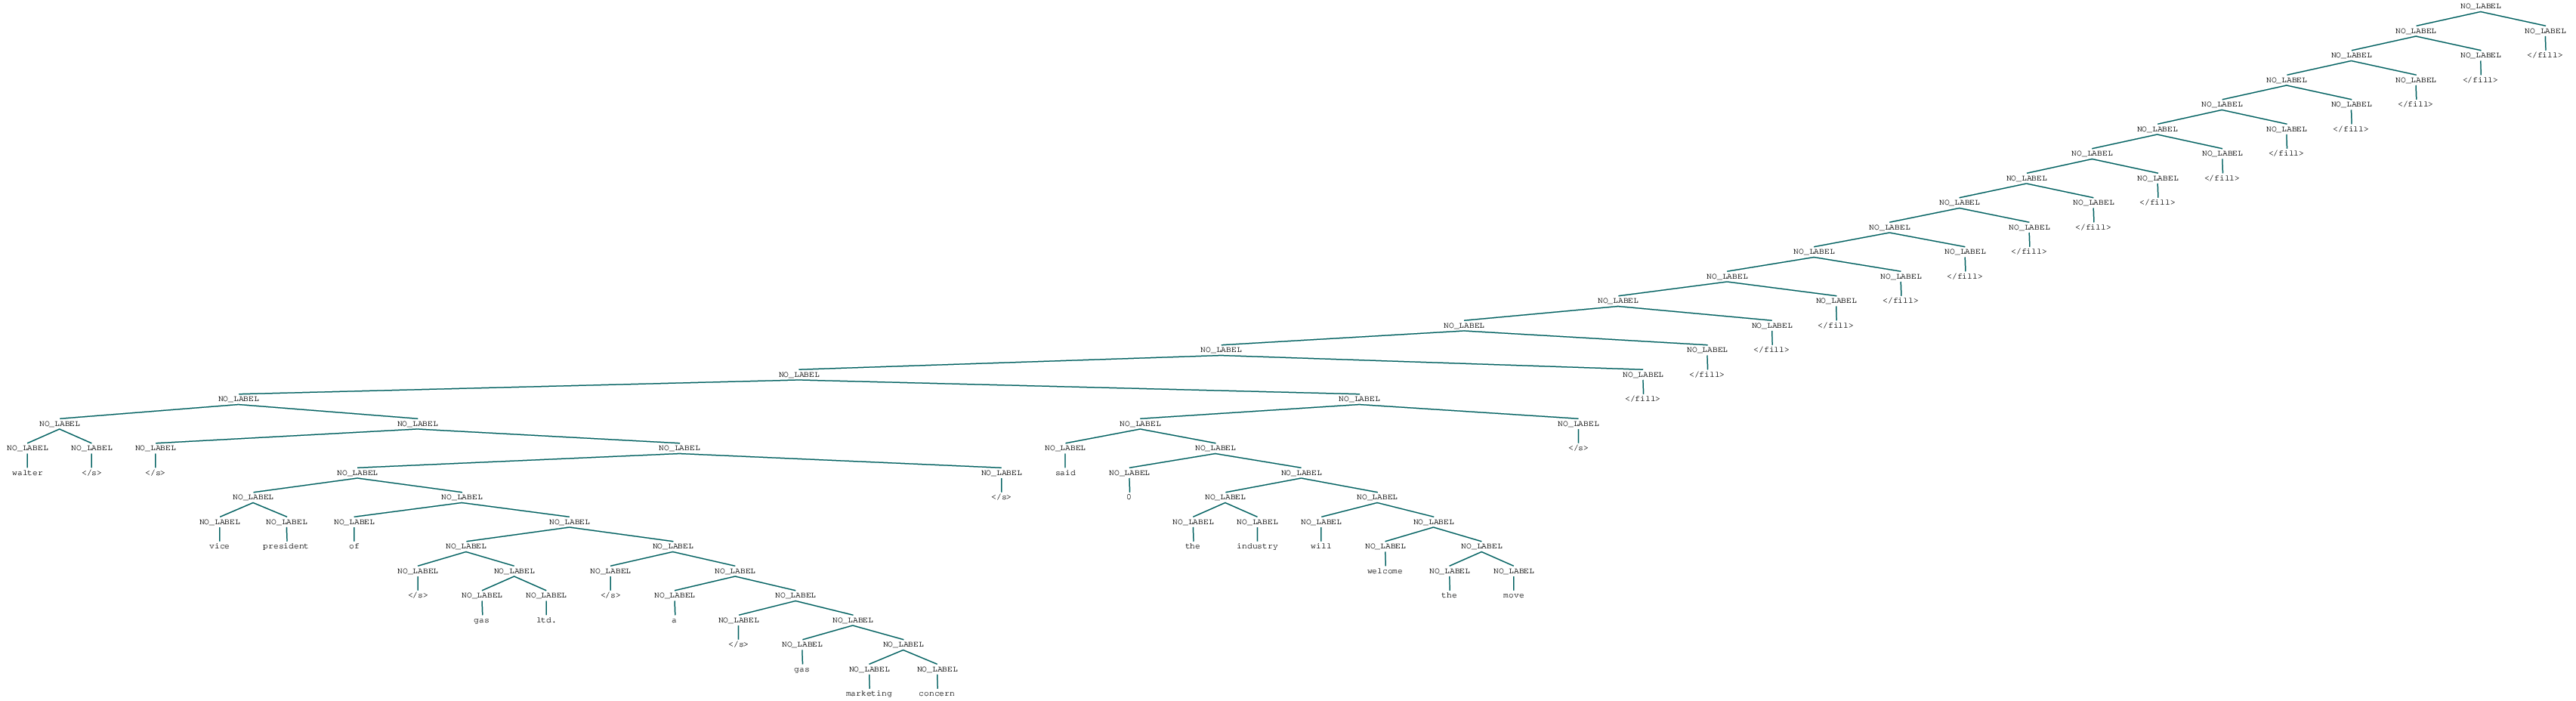

In [293]:
result_set.iloc[0]['tree']

In [294]:
result_set.to_csv('result.csv',header=False,index=False)

### Approximately 
* it takes about ~2 minutes (112 seconds) for completing 1 epoch which is ~35000 sentences